Intro:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.69411767..0.49803925].


Training samples: 10175
Classes: ['Basophil', 'Eosinophil', 'Lymphocyte', 'Monocyte', 'Neutrophil']


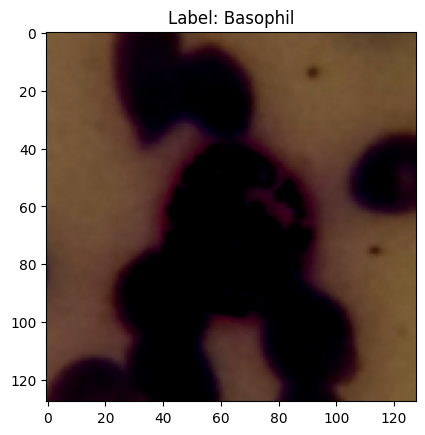

In [4]:
# Data
import numpy as np
import math
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


transform = transforms.Compose([
    transforms.Resize((128, 128)),  #resize all images to 128x128
    transforms.ToTensor(),         #convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


train_dataset = datasets.ImageFolder(root='dataset/Train', transform=transform)
testA_dataset = datasets.ImageFolder(root='dataset/TestA', transform=transform)
testB_dataset = datasets.ImageFolder(root='dataset/Test-B', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
testA_loader = DataLoader(testA_dataset, batch_size=32, shuffle=False)
testB_loader = DataLoader(testB_dataset, batch_size=32, shuffle=False)


# TEST AND VISUALIZE DATASET BELOW ------------------------------------------------
print(f"Training samples: {len(train_dataset)}")
print(f"Classes: {train_dataset.classes}")

import matplotlib.pyplot as plt
image, label = train_dataset[0]  #this shows the first image under the train dataset (first image under basophil)
plt.imshow(image.permute(1, 2, 0))  #convert (C, H, W) to (H, W, C) so matplotlib can recognize image.
plt.title(f"Label: {train_dataset.classes[label]}")
plt.show() # Note!!! The image is normalized, so it looks pretty dark when plt.show().


In [5]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Convolutional Neural Network

Since the Raabin WBC dataset provides an image classification problem, it's inevitable that we chose to experiment with a CNN. A CNN mimics how our eyes and brain handle vision. Signals pass through the lateral geniculate nucleus (LGN) and into the visual cortex, where the first layer (V1) detects simple edges and later layers build more complex shapes. Similarly, a CNN learns with small weight matrices, called “filters", that slide over every part of an image acting like those V1 edge detectors but with shared weights so the same feature is recognized no matter where it appears. Weight sharing is vital to our problem, since the white blood cells are captured with a microscope and can appear at any place in any orientation on the slide. Since each filter has only a small number of parameters yet interacts with the whole picture, a CNN captures local patterns efficiently, keeps the model compact compared with a fully connected alternative, and provides the translation-invariant features we need for reliable image classification.

In [16]:
import torch, math, itertools, copy, random
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from sklearn.model_selection import KFold
import pandas as pd
SEED = 42
torch.manual_seed(SEED); random.seed(SEED)

tfm = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

root = "dataset/Train"
full_ds = datasets.ImageFolder(root, transform=tfm)
num_classes = len(full_ds.classes)

import torch.nn as nn, torch.nn.functional as F
class CNN(nn.Module):
    def __init__(self, nf=16, dropout=0.3, num_classes=3):
        super().__init__()
        self.conv1 = nn.Conv2d(3, nf, 5)
        self.conv2 = nn.Conv2d(nf, nf, 5)
        self.conv3 = nn.Conv2d(nf, nf * 2, 5)
        self.pool  = nn.MaxPool2d(2)
        flat = (nf * 2) * 28 * 28
        self.fc1  = nn.Linear(flat, 256)
        self.fc2  = nn.Linear(256, num_classes)
        self.dp   = dropout
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = x.flatten(1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=self.dp, training=self.training)
        return self.fc2(x)

def make_model(hp):
    return CNN(nf=hp["nf"], dropout=hp["drop"], num_classes=num_classes)

Overall, our network is a standard CNN with three 5 × 5 convolution blocks that scan the image for local patterns edges in the first block, small cell parts in the second, and entire cell structures in the third. Max pooling after the second and third blocks shrinks the height and width of the feature maps by half, which makes the detections slightly tolerant to small translations or focus discrepencies that can occur with microscope captures. Once the spatial information has been condensed to a 28 × 28 grid of 32 channels, we flatten the tensor and pass it to a 256-unit fully connected layer. This stage lets the model mix features from every area of the image so it can reason about entire cell structures instead of isolated segments. A ReLU activation injects non linearity, and a 30 % dropout rate switches off random neurons during training, breaking up fragile dependencies and reduces over-fitting on our relatively small dataset. Finally, the network ends with a linear layer that outputs three logits, one per white-blood-cell class, so a softmax can pick the most probable label.

Hyperparameter descriptions:

Learning rate (lr) – Sets the size of each weight-update step that Adam takes during back-propagation.
Number of filters (nf) – This is the channel count in the very first convolution layer.
Dropout rate (drop) – Applied to the 256-unit dense layer, this is the fraction of activations randomly zeroed during training. 
Batch size (bs) – The number of training images processed before one optimisation step.

In [ ]:
device = (
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)

print("Using device:", device)

def run_epoch(model, loader, optimizer=None, device=device):
    train = optimizer is not None
    model.train(train)
    loss_fn = nn.CrossEntropyLoss()
    running, correct = 0.0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        if train: optimizer.zero_grad()
        out  = model(x)
        loss = loss_fn(out, y)
        if train:
            loss.backward(); optimizer.step()
        running += loss.item() * y.size(0)
        correct += (out.argmax(1) == y).sum().item()
    n = len(loader.dataset)
    return running / n, correct / n

# H-param grid search
EPOCHS = 6
kfold  = KFold(n_splits=5, shuffle=True, random_state=SEED)

param_grid = {
    "lr"   : [3e-4, 1e-3],
    "nf"   : [16, 32],
    "drop" : [0.25, 0.4],
    "bs"   : [32],
}
def product(d):
    keys, vals = zip(*d.items())
    for combo in itertools.product(*vals):
        yield dict(zip(keys, combo))

hp_rows = []
fold_rows = []

for hp in product(param_grid):
    print("Testing HP combination:", hp)
    fold_metrics = []
    for fold, (idx_tr, idx_val) in enumerate(kfold.split(range(len(full_ds))), 1):
        tr_ds  = Subset(full_ds, idx_tr)
        val_ds = Subset(full_ds, idx_val)
        tr_ld  = DataLoader(tr_ds,  batch_size=hp["bs"], shuffle=True,  num_workers=2)
        val_ld = DataLoader(val_ds, batch_size=hp["bs"], shuffle=False, num_workers=2)

        model = make_model(hp).to(device)
        optim = torch.optim.Adam(model.parameters(), lr=hp["lr"])
        for _ in range(EPOCHS):
            run_epoch(model, tr_ld, optim, device)
        _, acc = run_epoch(model, val_ld, None, device)
        print(f"Fold {fold} | {hp} | {acc:.2%}")
        # Save fold metrics and rows
        fold_metrics.append(acc)
        fold_rows.append({**hp, "fold": fold, "val_acc": acc})

    hp_rows.append({**hp, "mean_acc": sum(fold_metrics) / len(fold_metrics)})

# DataFrames
fold_df = pd.DataFrame(fold_rows)
grid_df = pd.DataFrame(hp_rows)

best = grid_df.sort_values("mean_acc", ascending=False).iloc[0]
best_hp = best[["lr", "nf", "drop", "bs"]].to_dict()
best_acc = best["mean_acc"]

print("Best Hyperparameter Configuration:", best_hp, f"with {best_acc:.2%} accuracy")

Using device: cuda
Fold 1 | {'lr': 0.0003, 'nf': 16, 'drop': 0.25, 'bs': 32}
Fold 1 | {'lr': 0.0003, 'nf': 16, 'drop': 0.25, 'bs': 32} | 93.86%
Fold 2 | {'lr': 0.0003, 'nf': 16, 'drop': 0.25, 'bs': 32}
Fold 2 | {'lr': 0.0003, 'nf': 16, 'drop': 0.25, 'bs': 32} | 94.84%
Fold 3 | {'lr': 0.0003, 'nf': 16, 'drop': 0.25, 'bs': 32}
Fold 3 | {'lr': 0.0003, 'nf': 16, 'drop': 0.25, 'bs': 32} | 95.58%
Fold 4 | {'lr': 0.0003, 'nf': 16, 'drop': 0.25, 'bs': 32}
Fold 4 | {'lr': 0.0003, 'nf': 16, 'drop': 0.25, 'bs': 32} | 94.10%
Fold 5 | {'lr': 0.0003, 'nf': 16, 'drop': 0.25, 'bs': 32}
Fold 5 | {'lr': 0.0003, 'nf': 16, 'drop': 0.25, 'bs': 32} | 94.89%
Fold 1 | {'lr': 0.0003, 'nf': 16, 'drop': 0.4, 'bs': 32}
Fold 1 | {'lr': 0.0003, 'nf': 16, 'drop': 0.4, 'bs': 32} | 94.59%
Fold 2 | {'lr': 0.0003, 'nf': 16, 'drop': 0.4, 'bs': 32}
Fold 2 | {'lr': 0.0003, 'nf': 16, 'drop': 0.4, 'bs': 32} | 95.14%
Fold 3 | {'lr': 0.0003, 'nf': 16, 'drop': 0.4, 'bs': 32}
Fold 3 | {'lr': 0.0003, 'nf': 16, 'drop': 0.4, 'bs': 

To begin, run_epoch is our training/evaluation routine. Given a model and data loader it loops over each batch, passes data to the device, computes the loss with CrossEntropyLoss. Then, if an optimiser is supplied, it performs back propagation and a parameter update. Along the way it keeps track of the total loss and correct predictions to return averages for every epoch. We then start a hyper-parameter grid search. Six epochs is enough to see whether or not a setting is promising without spending hours on every trial. KFold splits the dataset into five folds where each image serves as validation data once and  as training data four times.. The grid explores two learning rates (3 × 10⁻⁴, 1 × 10⁻³), two filter counts (16, 32), two dropout rates (0.25, 0.4), and a single batch size (32), for 2 × 2 × 2 = 8 total combinations. For each combination we train a new model on every fold, record the folds accuracy, and store both results per fold and per combo means in lists that become Panda DataFrames (fold_df, grid_df). After this, we simply sort grid_df by mean accuracy, grab the top row, and report the corresponding hyperparameter dictionary and its average accuracy over the 5 folds. To summarize, the code chooses the highest performing learning rate, filter width, and dropout level while storing it in DataFrames.

In [ ]:
# ───────────────── Train final model ─────────────────
best = grid_df.sort_values("mean_acc", ascending=False).iloc[0]
best_hp = {
    "lr"  : float(best["lr"]),
    "nf"  : int(best["nf"]),
    "drop": float(best["drop"]),
    "bs"  : int(best["bs"])
}
best_model   = make_model(best_hp).to(device)
train_loader = DataLoader(full_ds, batch_size=best_hp["bs"], shuffle=True)
optim        = torch.optim.Adam(best_model.parameters(), lr=best_hp["lr"])

epoch_rows = []
for epoch in range(15):
    tr_loss, tr_acc = run_epoch(best_model, train_loader, optim, device)
    epoch_rows.append({"epoch": epoch+1, "loss": tr_loss, "acc": tr_acc})

final_df = pd.DataFrame(epoch_rows)

# clean up for output
pretty_df = (
    final_df
      .rename(columns={"acc": "accuracy"})
      .round({"loss": 4})
)

print(
    pretty_df
      .to_string(
          index=False,
          formatters={"accuracy": "{:.2%}".format}
      )
)

 epoch   loss accuracy
     1 0.3870   85.84%
     2 0.1659   94.04%
     3 0.0982   96.71%
     4 0.0618   97.85%
     5 0.0371   98.82%
     6 0.0274   99.17%
     7 0.0235   99.18%
     8 0.0130   99.59%
     9 0.0127   99.63%
    10 0.0166   99.42%
    11 0.0075   99.74%
    12 0.0110   99.67%
    13 0.0105   99.65%
    14 0.0084   99.73%
    15 0.0120   99.61%


After the grid search settles on the best hyper-parameter mix, this block starts up one last CNN with those settings, trains it on all the images for 15 epochs, and logs how well it’s learning. Based on the final output, the model’s loss is steadily dropping while accuracy increases toward the high 90-percent mark, confirming that the chosen hyper-parameter yield a high performance final classifier.

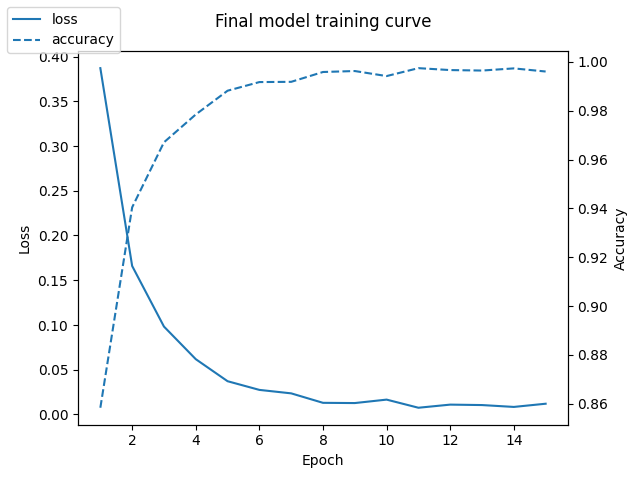

In [22]:
# Training curve 
fig1, ax1 = plt.subplots()
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.plot(final_df["epoch"], final_df["loss"], label="loss")

ax2 = ax1.twinx() # second axis for accuracy
ax2.set_ylabel("Accuracy")
ax2.plot(final_df["epoch"], final_df["acc"],
         linestyle="--", label="accuracy")

fig1.suptitle("Final model training curve")
fig1.tight_layout()
fig1.legend(loc="upper left")
plt.show()



On the very first epoch the loss is still around 0.40 and accuracy is only about 86 %, so the network’s weights seem random as its guessing a lot of cells incorrectly. Skipping to around epoch 10, the loss bottoms out just above 0.01 and accuracy is right under 100%, with small discrepencies that are likely just dropout noise rather than real performance changes. The fact that loss never spikes and accuracy doesn’t collapse suggests we aren’t over-fitting on the full dataset because the model keeps improving or keeping steady. Overall, the curve shows the CNN converged quickly, reached a very low error rate, and then stabilised, so fifteen epochs looks adequate for our dataset.

In [ ]:
import torch, math, itertools, copy, random
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from sklearn.model_selection import KFold
SEED = 42
torch.manual_seed(SEED); random.seed(SEED)

tfm = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

root = "dataset/Train"
full_ds = datasets.ImageFolder(root, transform=tfm)
num_classes = len(full_ds.classes)
print(f"Total imgs: {len(full_ds)}   classes: {full_ds.classes}")


import torch.nn as nn, torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, nf=16, dropout=0.3, num_classes=3):
        super().__init__()
        self.conv1 = nn.Conv2d(3, nf, 5)
        self.conv2 = nn.Conv2d(nf, nf, 5)
        self.conv3 = nn.Conv2d(nf, nf * 2, 5)
        self.pool  = nn.MaxPool2d(2)
        flat = (nf * 2) * 28 * 28
        self.fc1  = nn.Linear(flat, 256)
        self.fc2  = nn.Linear(256, num_classes)
        self.dp   = dropout

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = x.flatten(1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=self.dp, training=self.training)
        return self.fc2(x)

def make_model(hp):
    return CNN(nf=hp["nf"], dropout=hp["drop"], num_classes=num_classes)

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(torch.version.cuda)
print(f"Using device: {device}")

def run_epoch(model, loader, optimizer=None, device=device):
    train = optimizer is not None
    model.train(train)
    loss_fn = nn.CrossEntropyLoss()
    running, correct = 0.0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        if train: optimizer.zero_grad()
        out  = model(x)
        loss = loss_fn(out, y)
        if train:
            loss.backward(); optimizer.step()
        running += loss.item() * y.size(0)
        correct += (out.argmax(1) == y).sum().item()
    n = len(loader.dataset)
    return running / n, correct / n

EPOCHS = 6
kfold  = KFold(n_splits=5, shuffle=True, random_state=SEED)

param_grid = {
    "lr"   : [3e-4, 1e-3],
    "nf"   : [16, 32],
    "drop" : [0.25, 0.4],
    "bs"   : [32],
}

def product(d):
    keys, vals = zip(*d.items())
    for combo in itertools.product(*vals):
        yield dict(zip(keys, combo))

results = []

for hp in product(param_grid):
    print(f"\n▶ Testing hyper-params: {hp}")
    fold_metrics = []
    for fold, (idx_tr, idx_val) in enumerate(kfold.split(range(len(full_ds))), 1):
        tr_ds  = Subset(full_ds, idx_tr)
        val_ds = Subset(full_ds, idx_val)
        tr_ld  = DataLoader(tr_ds,  batch_size=hp["bs"], shuffle=True,  num_workers=2)
        val_ld = DataLoader(val_ds, batch_size=hp["bs"], shuffle=False, num_workers=2)

        model     = make_model(hp).to(device)
        optim     = torch.optim.Adam(model.parameters(), lr=hp["lr"])
        for _ in range(EPOCHS):
            run_epoch(model, tr_ld, optim, device)
        _, acc = run_epoch(model, val_ld, None, device)
        fold_metrics.append(acc)
        print(f"  Fold {fold}: val_acc = {acc:.3%}")

    mean_acc = sum(fold_metrics) / len(fold_metrics)
    results.append((mean_acc, hp))
    print(f"  → mean 5-fold accuracy: {mean_acc:.3%}")

best_acc, best_hp = max(results, key=lambda x: x[0])
print("\nBest setting:", best_hp, f"with {best_acc:.2%} accuracy")

best_model   = make_model(best_hp).to(device)
train_loader = DataLoader(full_ds, batch_size=best_hp["bs"], shuffle=True)
optim        = torch.optim.Adam(best_model.parameters(), lr=best_hp["lr"])

for epoch in range(15):
    tr_loss, tr_acc = run_epoch(best_model, train_loader, optim, device)
    print(f"Epoch {epoch+1:>2}: loss {tr_loss:.4f}  acc {tr_acc:.3%}")



Total imgs: 10175   classes: ['Basophil', 'Eosinophil', 'Lymphocyte', 'Monocyte', 'Neutrophil']
12.4
Using device: cuda

▶ Testing hyper-params: {'lr': 0.0003, 'nf': 16, 'drop': 0.25, 'bs': 32}
  Fold 1: val_acc = 93.514%
  Fold 2: val_acc = 94.447%
  Fold 3: val_acc = 94.742%
  Fold 4: val_acc = 93.956%
  Fold 5: val_acc = 94.939%
  → mean 5-fold accuracy: 94.319%

▶ Testing hyper-params: {'lr': 0.0003, 'nf': 16, 'drop': 0.4, 'bs': 32}
  Fold 1: val_acc = 93.808%
  Fold 2: val_acc = 94.300%
  Fold 3: val_acc = 94.889%
  Fold 4: val_acc = 95.381%
  Fold 5: val_acc = 94.300%
  → mean 5-fold accuracy: 94.536%

▶ Testing hyper-params: {'lr': 0.0003, 'nf': 32, 'drop': 0.25, 'bs': 32}
  Fold 1: val_acc = 93.661%
  Fold 2: val_acc = 94.791%
  Fold 3: val_acc = 96.413%
  Fold 4: val_acc = 94.054%
  Fold 5: val_acc = 94.840%
  → mean 5-fold accuracy: 94.752%

▶ Testing hyper-params: {'lr': 0.0003, 'nf': 32, 'drop': 0.4, 'bs': 32}
  Fold 1: val_acc = 94.988%
  Fold 2: val_acc = 95.381%
  Fold 3

Explaining CNN

In [4]:
# Vision Transformer
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

# Image size for ViT/ResNet
IMG_SIZE = 224

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # For grayscale images adjust if needed
])

train_dataset = datasets.ImageFolder('dataset/Train', transform=train_transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

Conclusion:
